In [355]:
%matplotlib notebook

import os
import sys
sys.path.append("lib") # go to parent dir
import pickle

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import nibabel as nib
from PIL import Image
import seaborn as sns
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import lib.motion as motion
import lib.models as models
import lib.mri_data_generator as mri_data_generator

In [360]:
n = 64
num_lines = None
batch_size = 8

# Set up model
model = models.get_theta_k_model((n,n,2),single=True)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights

training_dir = 'training/ismrm-64/BRAIN-ALL-CONTIGUOUS-PATCHFalse-PARAMETERIZED_SINGLE_THETA-relu-FREQUENCY_INDOMAIN-SINGLE_THETA_K_OUTDOMAIN-False-5000epoch-64-*single_theta_k_256/'
model.load_weights(training_dir+'cp-0900.ckpt')

In [361]:
adni_dir_train='/data/vision/polina/scratch/nmsingh/ADNI-data/uncropped/adni-split-by-subj-slice128-axial/train/vols'
adni_dir_val='/data/vision/polina/scratch/nmsingh/ADNI-data/uncropped/adni-split-by-subj-slice128-axial/test/vols'

In [362]:
with open(training_dir+'train_generator.pkl', 'rb') as pickle_file:
    train_generator = pickle.load(pickle_file)
with open(training_dir+'test_generator.pkl', 'rb') as pickle_file:
    val_generator = pickle.load(pickle_file)

In [363]:
train_model_outs = model.predict_generator(train_generator)
val_model_outs = model.predict_generator(val_generator)

In [364]:
train_true_outs = np.empty((0,1,4))
for i in range(len(train_generator)):
    train_true_outs = np.append(train_true_outs,train_generator[i][1],axis=0)
    
val_true_outs = np.empty((0,1,4))
for i in range(len(val_generator)):
    val_true_outs = np.append(val_true_outs,val_generator[i][1],axis=0)

In [365]:
def get_errors_by_line(ind):
    train_line_errors = []
    train_line_stds = []
    val_line_errors = []
    val_line_stds = []
    errors = np.abs(val_true_outs[:,:,ind]-val_model_outs[:,:,ind])
    for i in range(64):
        train_mae = np.mean(errors[train_true_outs[:,:,3]==i])
        train_std = np.std(errors[train_true_outs[:,:,3]==i])
        train_line_errors.append(train_mae)
        train_line_stds.append(train_std)
        val_mae = np.mean(errors[val_true_outs[:,:,3]==i])
        val_std = np.std(errors[val_true_outs[:,:,3]==i])
        val_line_errors.append(val_mae)
        val_line_stds.append(val_std)
    return((np.array(train_line_errors,train_line_stds,val_line_errors,val_line_stds)))

<IPython.core.display.Javascript object>


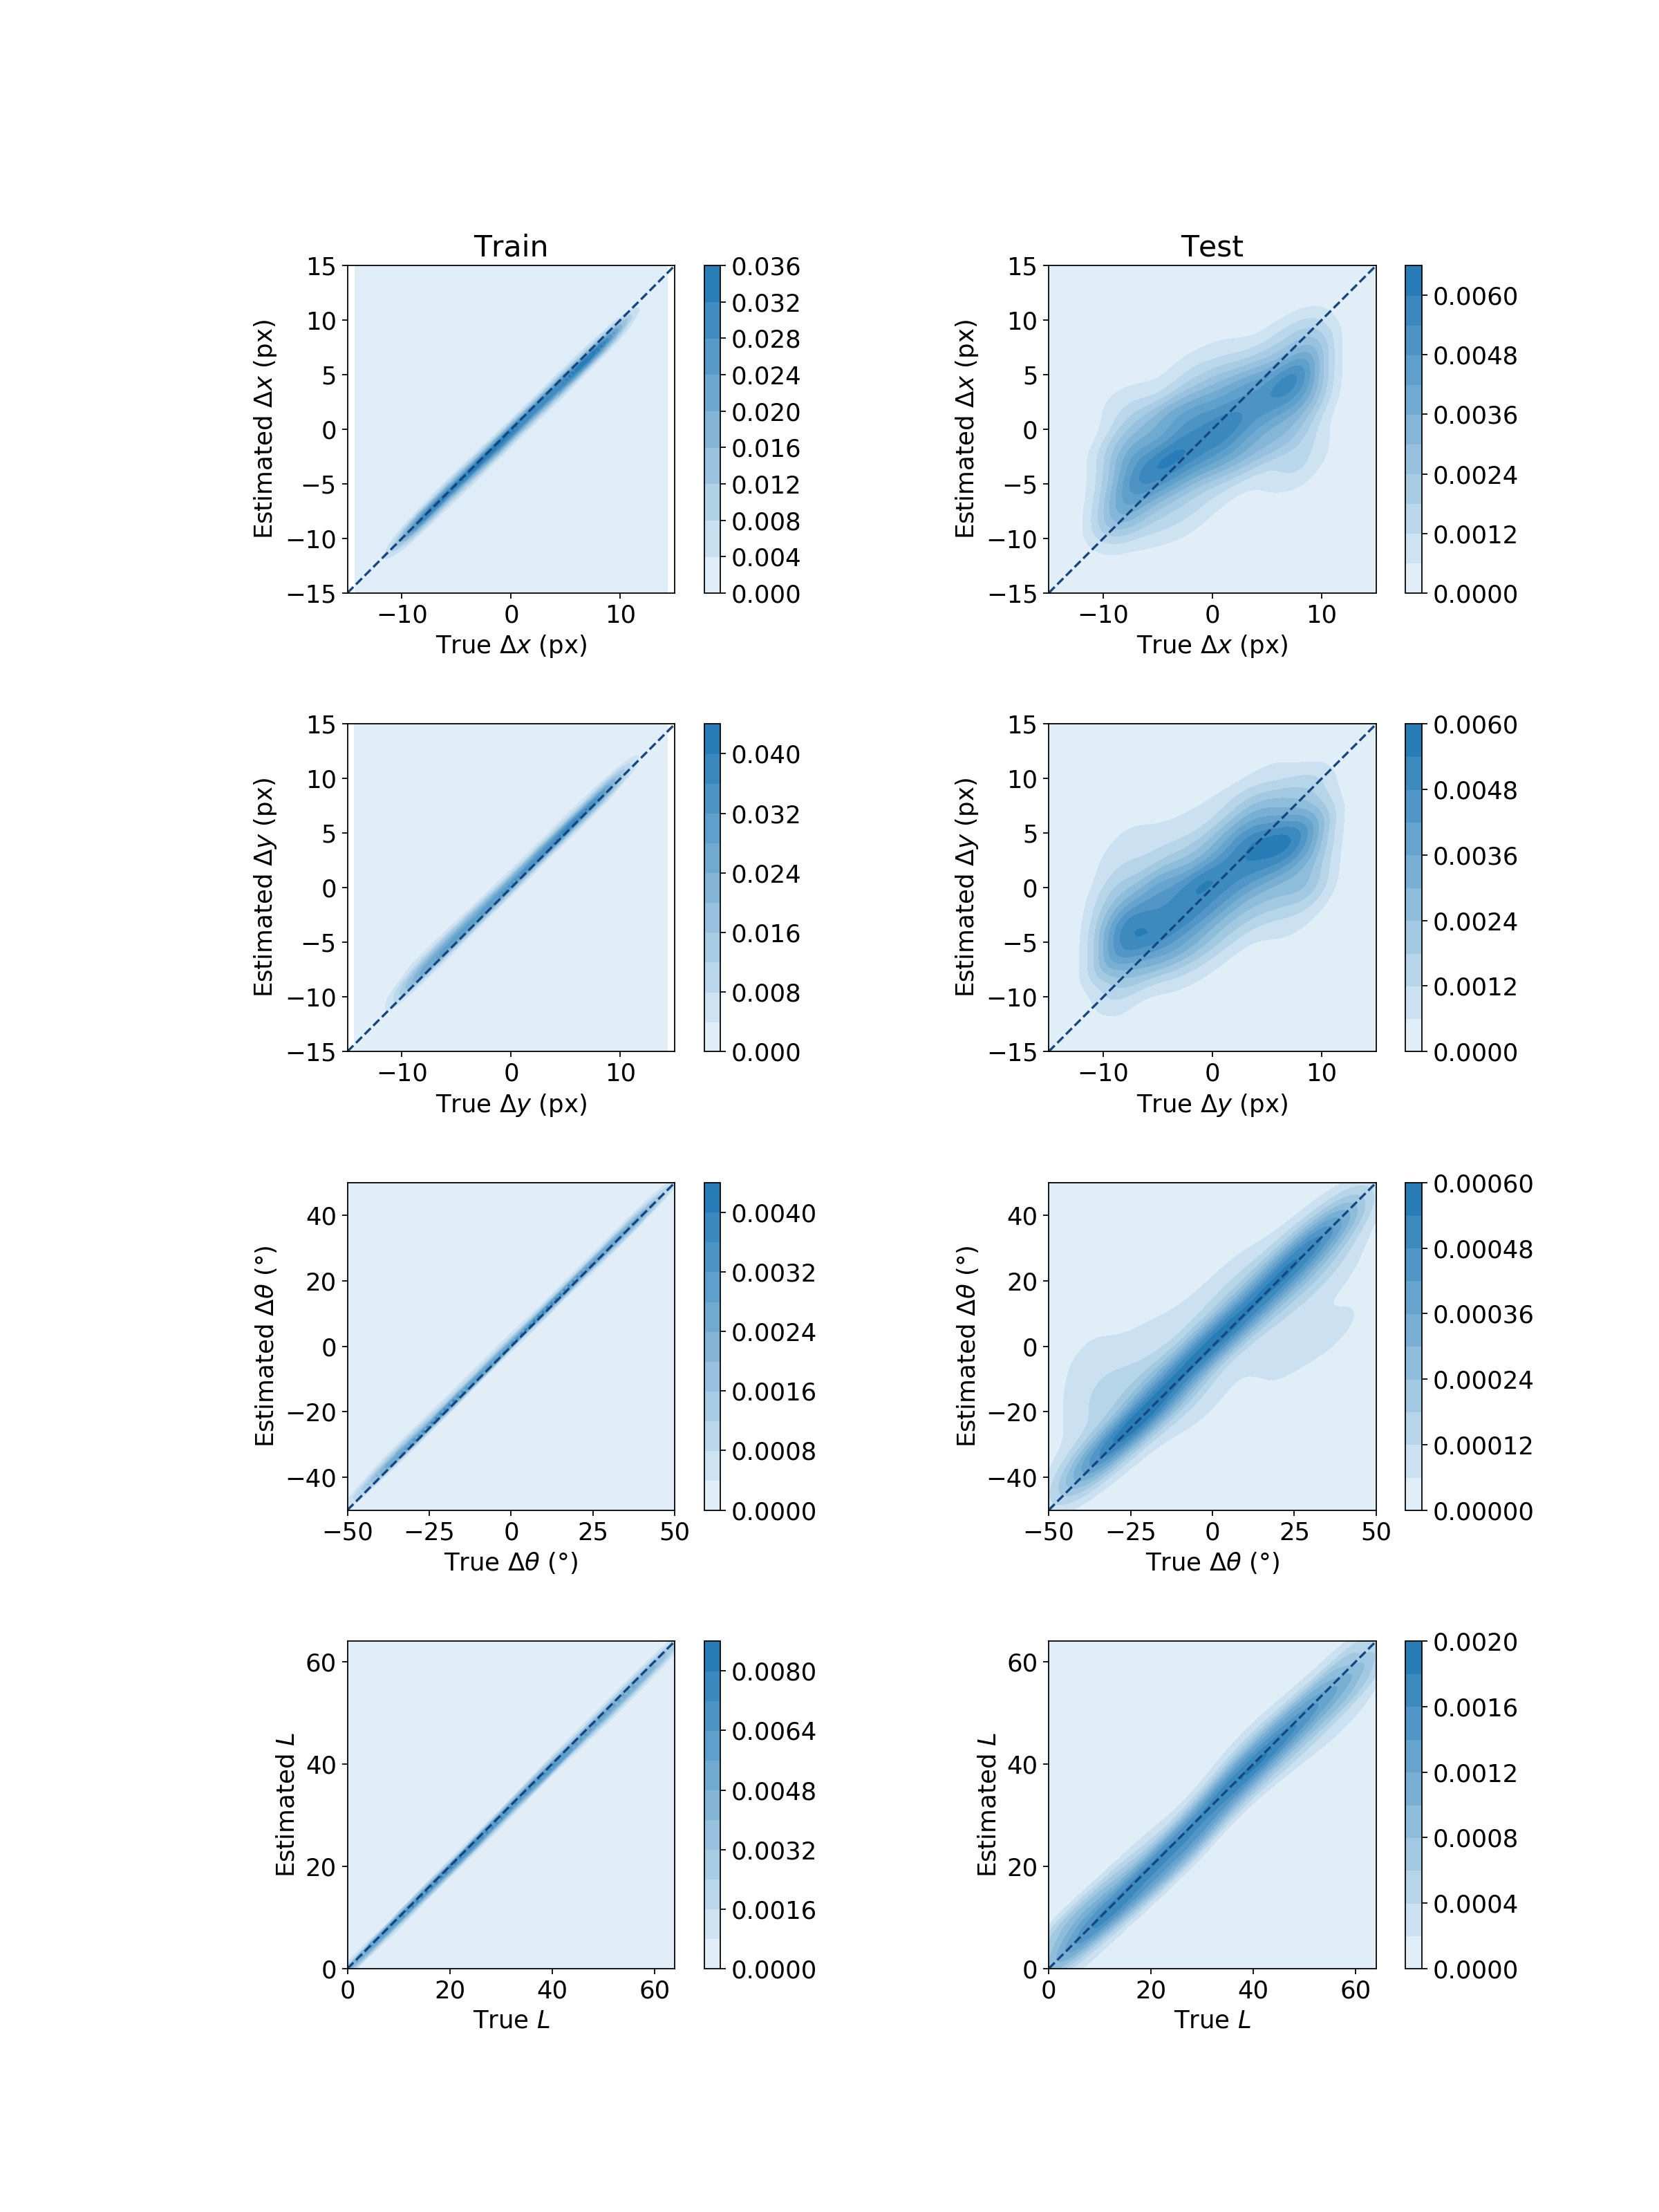

/data/vision/polina/scratch/nmsingh/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  s)


In [376]:
plt.rcParams.update({'font.size': 16})
num_scatter = -1
fig, axes = plt.subplots(4, 2, figsize=(15,20))

sns.kdeplot(train_true_outs[:num_scatter,:,0].flatten(),train_model_outs[:num_scatter,:,0].flatten(), shade=True, cbar=True, ax=axes[0][0], xlim=[-10,10], ylim=[-10,10])
axes[0][0].set(xlabel='True $\Delta{x}$ (px)', ylabel='Estimated $\Delta{x}$ (px)', xlim=[-15,15],ylim=[-15,15])
axes[0][0].plot([-15,15],[-15,15],'--',color='#144680')
axes[0][0].set_aspect('equal')
axes[0][0].set_title('Train')
#r_2 = r2_score(train_true_outs[:num_scatter,:,0].flatten(),train_model_outs[:num_scatter,:,0].flatten())
#axes[0][0].text(-15,15,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(val_true_outs[:num_scatter,:,0].flatten(),val_model_outs[:num_scatter,:,0].flatten(), shade=True, cbar=True, ax=axes[0][1], xlim=[-10,10], ylim=[-10,10])
axes[0][1].set(xlabel='True $\Delta{x}$ (px)', ylabel='Estimated $\Delta{x}$ (px)', xlim=[-15,15],ylim=[-15,15])
axes[0][1].plot([-15,15],[-15,15],'--',color='#144680')
axes[0][1].set_aspect('equal')
axes[0][1].set_title('Test')
#r_2 = r2_score(val_true_outs[:num_scatter,:,0].flatten(),val_model_outs[:num_scatter,:,0].flatten())
#axes[0][1].text(-15,15,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(train_true_outs[:num_scatter,:,1].flatten(),train_model_outs[:num_scatter,:,1].flatten(), shade=True, cbar=True, ax=axes[1][0], xlim=[-10,10], ylim=[-10,10])
axes[1][0].set(xlabel='True $\Delta{y}$ (px)', ylabel='Estimated $\Delta{y}$ (px)', xlim=[-15,15],ylim=[-15,15])
axes[1][0].plot([-15,15],[-15,15],'--',color='#144680')
axes[1][0].set_aspect('equal')
#r_2 = r2_score(train_true_outs[:num_scatter,:,1].flatten(),train_model_outs[:num_scatter,:,1].flatten())
#axes[1][0].text(-15,15,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(val_true_outs[:num_scatter,:,1].flatten(),val_model_outs[:num_scatter,:,1].flatten(), shade=True, cbar=True, ax=axes[1][1], xlim=[-10,10], ylim=[-10,10])
axes[1][1].set(xlabel='True $\Delta{y}$ (px)', ylabel='Estimated $\Delta{y}$ (px)', xlim=[-15,15],ylim=[-15,15])
axes[1][1].plot([-15,15],[-15,15],'--',color='#144680')
axes[1][1].set_aspect('equal')
#r_2 = r2_score(val_true_outs[:num_scatter,:,1].flatten(),val_model_outs[:num_scatter,:,1].flatten())
#axes[1][1].text(-15,15,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(train_true_outs[:num_scatter,:,2].flatten(),train_model_outs[:num_scatter,:,2].flatten(), shade=True, cbar=True, ax=axes[2][0], xlim=[-45,45], ylim=[-45,45])
axes[2][0].set(xlabel=r'True $\Delta \theta$ ($\degree$)', ylabel=r'Estimated $\Delta \theta$ ($\degree$)', xlim=[-50,50],ylim=[-50,50])
axes[2][0].plot([-50,50],[-50,50],'--',color='#144680')
axes[2][0].set_aspect('equal')
#r_2 = r2_score(train_true_outs[:num_scatter,:,2].flatten(),train_model_outs[:num_scatter,:,2].flatten())
#axes[2][0].text(-50,50,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(val_true_outs[:num_scatter,:,2].flatten(),val_model_outs[:num_scatter,:,2].flatten(), shade=True, cbar=True, ax=axes[2][1], xlim=[-45,45], ylim=[-45,45])
axes[2][1].set(xlabel=r'True $\Delta \theta$ ($\degree$)', ylabel=r'Estimated $\Delta \theta$ ($\degree$)', xlim=[-50,50],ylim=[-50,50])
axes[2][1].plot([-50,50],[-50,50],'--',color='#144680')
axes[2][1].set_aspect('equal')
#r_2 = r2_score(val_true_outs[:num_scatter,:,2].flatten(),val_model_outs[:num_scatter,:,2].flatten())
#axes[2][1].text(-50,50,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(train_true_outs[:num_scatter,:,3].flatten(),train_model_outs[:num_scatter,:,3].flatten(), shade=True, cbar=True, ax=axes[3][0], xlim=[-45,45], ylim=[-45,45])
axes[3][0].set(xlabel='True $L$', ylabel='Estimated $L$',xlim=[0,64],ylim=[0,64])
axes[3][0].plot([0,64],[0,64],'--',color='#144680')
axes[3][0].set_aspect('equal')
#r_2 = r2_score(train_true_outs[:num_scatter,:,3].flatten(),train_model_outs[:num_scatter,:,3].flatten())
#axes[3][0].text(0,64,'$R^2$ = '+str(round(r_2,2)))

sns.kdeplot(val_true_outs[:num_scatter,:,3].flatten(),val_model_outs[:num_scatter,:,3].flatten(), shade=True, cbar=True, ax=axes[3][1], xlim=[-45,45], ylim=[-45,45])
axes[3][1].set(xlabel='True $L$', ylabel='Estimated $L$', xlim=[0,64],ylim=[0,64])
axes[3][1].plot([0,64],[0,64],'--',color='#144680')
axes[3][1].set_aspect('equal')
#r_2 = r2_score(val_true_outs[:num_scatter,:,3].flatten(),val_model_outs[:num_scatter,:,3].flatten())
#axes[3][1].text(0,64,'$R^2$ = '+str(round(r_2,2)))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)#[source]

plt.savefig(training_dir+'kde.png')


In [367]:
np.mean(np.abs(val_true_outs[:,:,0]-val_model_outs[:,:,0]))

3.6230815848406976

In [368]:
np.mean(np.std(val_true_outs[:,:,1]-val_model_outs[:,:,1]))

4.713779535675983

In [369]:
np.mean(np.abs(val_true_outs[:,:,2]-val_model_outs[:,:,2]))

9.28926602164835

In [370]:
np.mean(np.abs(val_true_outs[:,:,3]-val_model_outs[:,:,3]))

3.1681030617659847